# M2M PLIMS Data Access Testing

#### Intro
Starting with the first deployment of the Coastal Pioneer Mid-Atlantic Bight (MAB) Array, OOI collected data from a plankton imaging instrument (McLane Research Labs Imaging Flow Cytobot) deployed at 7 meters depth on the near-surface instrument frame. The introduction of a new instrument to the physical OOI infrastructure required new parsing code and metadata to ingest the data into the OOI Cyberinfrastructure. Once ingested, the data will be available for machine-to-machine (M2M) download from OOI's THREDDS server and then pushed to Data Explorer on a near-real-time basis.

#### Purpose
Telemetered data from the first PLIMS deployment on Central Surface Mooring has been ingested into the Dev2 development platform where the relevant parsers are being tested. After the parameters and relevant metadata were decided upon, test NetCDFs were created for review to confirm that the parsers could create a valid and accurate dataset. This data pathway from ingested data to datasets asynchronously compiled on demand now must be tested from the perspective of a data user.

#### Objectives:

* Test Output: Request HDR science and engineering datasets with different request parameters.
* Dataset Review: Look for incorrect data values, types or metadata to provide feedback to CI. 

#### Supporting tools
If you want to run this notebook as-is, you will need to clone A. Reed's [ooinet repo](https://github.com/reedan88/OOINet) to your local machine and install it as a local dev repo (which adds it to your base path). You'll also need the [ooi_data_explorations repo](https://github.com/oceanobservatories/ooi-data-explorations). Lastly, you'll want to install the ```ioos_qc``` [python package](https://github.com/ioos/ioos_qc). 


In [1]:
# Import libraries
import os
import re
import gc
import io
import ast
import netrc
import pandas as pd
import numpy as np
import xarray as xr
import warnings
warnings.filterwarnings("ignore")
import glob

# Import dask
import dask
from dask.diagnostics import ProgressBar

# Import pyplot and show plots inline
import matplotlib.pyplot as plt
%matplotlib inline 

Import the M2M tool

In [2]:
from ooinet import M2M
from ooinet.Instrument.common import process_file

Import the relevant ooi_data_explorations tools

In [3]:
from ooi_data_explorations.combine_data import combine_datasets
from ooi_data_explorations.common import get_vocabulary

---
## Request and load the data
Sub in ooinet-dev2.intra.oceanobservatories.org into the avaialbe API urls


In [4]:
for key in M2M.URLS:
    url = M2M.URLS.get(key)
    if "opendap" in url:
        M2M.URLS[key] = re.sub("opendap", "opendap-dev2.intra", url)
    else:
        M2M.URLS[key] = re.sub("ooinet","ooinet-dev2.intra", url)

Sub in dev2 OOINet credentials from netrc file

In [5]:
try:
    nrc = netrc.netrc()
    M2M.AUTH = nrc.authenticators('ooinet-dev2.intra.oceanobservatories.org')
    M2M.login, M2M.password = M2M.AUTH[0], M2M.AUTH[2]
    if M2M.AUTH is None:
        raise RuntimeError(
            'No entry found for machine ``ooinet-dev2.intra.oceanobservatories.org`` in the .netrc file')
except FileNotFoundError as e:
    raise OSError(e, os.strerror(e.errno), os.path.expanduser('~'))

Search the Dev1 server for available datasets

In [6]:
M2M.URLS

{'data': 'https://ooinet-dev2.intra.oceanobservatories.org/api/m2m/12576/sensor/inv',
 'anno': 'https://ooinet-dev2.intra.oceanobservatories.org/api/m2m/12580/anno/find',
 'vocab': 'https://ooinet-dev2.intra.oceanobservatories.org/api/m2m/12586/vocab/inv',
 'asset': 'https://ooinet-dev2.intra.oceanobservatories.org/api/m2m/12587',
 'deploy': 'https://ooinet-dev2.intra.oceanobservatories.org/api/m2m/12587/events/deployment/inv',
 'preload': 'https://ooinet-dev2.intra.oceanobservatories.org/api/m2m/12575/parameter',
 'cal': 'https://ooinet-dev2.intra.oceanobservatories.org/api/m2m/12587/asset/cal',
 'fileServer': 'https://opendap-dev2.intra.oceanobservatories.org/thredds/fileServer/',
 'dodsC': 'https://opendap-dev2.intra.oceanobservatories.org/thredds/dodsC/',
 'goldCopy': 'https://thredds.dataexplorer.oceanobservatories.org/thredds/catalog/ooigoldcopy/public/',
 'goldCopy_fileServer': 'https://thredds.dataexplorer.oceanobservatories.org/thredds/fileServer/',
 'goldCopy_dodsC': 'https:/

In [7]:
ds_df = M2M.search_datasets(array="CP10CNSM")
ds_df.reset_index(inplace=True)
ds_df

Searching https://ooinet-dev2.intra.oceanobservatories.org/api/m2m/12576/sensor/inv/CP10CNSM


,index,array,node,instrument,refdes,url,deployments
0,0,CP10CNSM,RID27,07-PLIMSA000,CP10CNSM-RID27-07-PLIMSA000,https://ooinet-dev2.intra.oceanobservatories.o...,[1]
1,0,CP10CNSM,RID26,01-PRTSZA000,CP10CNSM-RID26-01-PRTSZA000,https://ooinet-dev2.intra.oceanobservatories.o...,[1]


Find the available datastreams for a given **refdes**

In [8]:
url = ds_df["url"][0]
url = "/".join((url, 'telemetered', 'turbd_a_instrument'))
# Query the preload data
preload_data = M2M.get_api(url)
preload_data

NOT FOUND


In [9]:
datastreams = M2M.get_datastreams("CP10CNSM-RID27-07-PLIMSA000")
datastreams

,refdes,method,stream
0,CP10CNSM-RID27-07-PLIMSA000,telemetered,plims_a_hdr_engineering
1,CP10CNSM-RID27-07-PLIMSA000,telemetered,plims_a_hdr_instrument


In [10]:
# Setup parameters needed to request data
refdes = datastreams.refdes[0]
method = datastreams.method[0]
stream = datastreams.stream[0]

#### Development
We may also want to examine new QARTOD tests which are on staging in the Dev-1 environment before they are moved to production. The Development environemt at ooinet-dev1-west.intra.oceanobservatories.org. In order to access data on Dev-1, you need to be granted access and be connected to the CI-West VPN (vpn-west.oceanobservatories.org) at Oregon State.

The Dev-1 environment has no "goldcopy" equivalent THREDDs catalog. Instead we'll have to do the normal request and wait for the datasets to be assembled and made available for download.

In [11]:
# Define a generic preprocessing routine. Do NOT use any of the ooi_data_explorations "process_instrument" methods. We want to be comparing "apples-to-apples" 
def preprocess(ds):
    ds = process_file(ds)
    return ds

In [12]:
# Import vocabulary
site, node, sensor = refdes.split('-', 2)
vocab = get_vocabulary(site, node, sensor)

In [ ]:
# Use the gold copy THREDDs datasets
thredds_url = M2M.get_thredds_url(refdes, method, stream, beginDT="2024-05-01T00:00:00.0", endDT="2024-05-15T00:00:00.0")
# Get the THREDDs catalog
thredds_catalog = M2M.get_thredds_catalog(thredds_url)
thredds_catalog = [x for x in thredds_catalog if "blank" not in x]

# Clean the THREDDs catalog
sensor_files, ancillary_files = M2M.clean_catalog(thredds_catalog, stream)

# Generate the urls to access and load the data
sensor_files = [re.sub("catalog.html\?dataset=", M2M.URLS["dodsC"], file) for file in sensor_files]



Waiting for request to process


In [14]:
# # For VEL3D data, which usually causes the request cell to crash, import from local folder
# refdes = "GS02HYPM-WFP03-05-VEL3DL000"
# vel3d_files = glob.glob(f"*{refdes}*", root_dir=os.path.expanduser("~\\dev0_vel3d"))
# foo = []
# for file in vel3d_files:
#     foo.append(os.path.expanduser("~\\dev0_vel3d\\") + file)
# vel3d_files = foo

# vel3d_files
# with ProgressBar():
#     data = xr.open_mfdataset(vel3d_files, preprocess=preprocess, parallel=True)

In [15]:
# Load the data
with ProgressBar():
    data = xr.open_mfdataset(sensor_files, parallel=True)
    

[########################################] | 100% Completed | 1.02 ss


In [16]:
# Check dataset content
data

<xarray.Dataset>
Dimensions:                                      (obs: 96, bin: 55)
Coordinates:
  * obs                                          (obs) int32 0 1 2 ... 93 94 95
  * bin                                          (bin) int32 0 1 2 ... 52 53 54
Data variables: (12/62)
    num_cells                                    (obs) float32 dask.array<chunksize=(96,), meta=np.ndarray>
    temperature_qartod_executed                  (obs) |S64 dask.array<chunksize=(96,), meta=np.ndarray>
    ensemble_number                              (obs) float32 dask.array<chunksize=(96,), meta=np.ndarray>
    transducer_depth                             (obs) float32 dask.array<chunksize=(96,), meta=np.ndarray>
    pitch                                        (obs) float32 dask.array<chunksize=(96,), meta=np.ndarray>
    eastward_seawater_velocity_qartod_executed   (obs, bin) |S64 dask.array<chunksize=(96, 55), meta=np.ndarray>
    ...                                           ...
    correlation_magnitude_beam2                  (obs, bin) float32 dask.array<chunksize=(96, 55), meta=np.ndarray>
    correlation_magnitude_beam3                  (obs, bin) float32 dask.array<chunksize=(96, 55), meta=np.ndarray>
    correlation_magnitude_beam1                  (obs, bin) float32 dask.array<chunksize=(96, 55), meta=np.ndarray>
    echo_intensity_beam4                         (obs, bin) float32 dask.array<chunksize=(96, 55), meta=np.ndarray>
    echo_intensity_beam3                         (obs, bin) float32 dask.array<chunksize=(96, 55), meta=np.ndarray>
    echo_intensity_beam1                         (obs, bin) float32 dask.array<chunksize=(96, 55), meta=np.ndarray>
Attributes: (12/73)
    node:                               RIM01
    comment:                            
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_inst
    stream:                             adcp_velocity_earth
    ...                                 ...
    geospatial_vertical_positive:       down
    lat:                                -42.49601667
    lon:                                -42.12545
    DODS.strlen:                        18
    DODS.dimName:                       string18
    DODS_EXTRA.Unlimited_Dimension:     obs

In [17]:
def swap_timestamps(ds):
    """
    Swaps the timestamps from the host to the instrument timestamp
    for the CTDBPs
    """
    if "internal_timestamp" in ds.variables:
        # Calculate the timestamp
        inst_time = ds.internal_timestamp.to_pandas()
        attrs = ds.internal_timestamp.attrs
        # Convert the time
        inst_time = inst_time.apply(lambda x: np.datetime64(int(x), 's'))
        # Create a DataArary
        da = xr.DataArray(inst_time, attrs=attrs)
        ds['internal_timestamp'] = da
    ds = ds.set_coords(["internal_timestamp"])
    ds = ds.swap_dims({"time":"internal_timestamp"})
    ds = ds.reset_coords("time")
    ds = ds.rename_vars({"time":"host_time"})
    ds["host_time"].attrs = {
        "long_name": "DCL Timestamp",
        "comment": ("The timestamp that the instrument data as recorded by the mooring data "
                    "concentration logger (DCL)")
    }
    ds = ds.rename({"internal_timestamp":"time"})
    return ds

#### Identify Test Parameters
Next, identify which parameters in the dataset have QARTOD applied to them. Sometimes the variable name in the dataset is different that the key that is used by OOINet to build the datasets. For that we can check the attributes of the variable for the "alternate_parameter_name"!

In [18]:
# Create a dictionary of key-value pairs of dataset variable name:alternate parameter name
test_parameters={}
for var in data.variables:
    if "qartod_results" in var:
        # Get the parameter name
        param = var.split("_qartod")[0]
        
        # Check if the parameter has an alternative ooinet_name
        if "alternate_parameter_name" in data[param].attrs:
            ooinet_name = data[param].attrs["alternate_parameter_name"]
        else:
            ooinet_name = param
        
        # Safe the results in a dictionary
        test_parameters.update({
            param: ooinet_name
        })
# Print out the results
test_parameters

{'roll': 'roll',
 'pitch': 'pitch',
 'temperature': 'temperature',
 'eastward_seawater_velocity': 'eastward_seawater_velocity',
 'bin_depths': 'bin_depths',
 'northward_seawater_velocity': 'northward_seawater_velocity'}

---
## Testing & Verification

To verify the results of the QARTOD tests being run by OOINet, we want to compare the QARTOD flags returned with the datasets against the results from running the tests locally using the same inputs. First, we have to parse out the separate test results from the ```qartod_executed``` variable. Then, we parse and load the appropriate gitHub tables. With the correct input tables, we can then run the different tests locally. Finally, we directly compare the locally-run results against what was returned with the dataset and identify any disagreements. 

#### Parse the QARTOD Executed
The ```qartod_executed``` variable for a given parameter contains the individual QARTOD test flags. For each datum, flags are listed in a string matching the order of the tests_executed attribute. Flags should be interpreted using the standard QARTOD mapping: \[1: pass, 2: not_evaluated, 3: suspect_or_of_high_interest, 4: fail, 9: missing_data\].

For verification, we first want to split out each test into its own separate variable, named using the following convention: {param}\_qartod\_{test_name}. For example, parsing out the gross range test results for the CTD parameter ```sea_water_practical_salinity``` from the qartod flags ```sea_water_practical_salinity_qartod_executed``` will return a variable ```sea_water_practical_salinity_qartod_gross_range``` with just flags corresponding to the results of the gross range QARTOD test.

In [19]:
import io
import ast
import requests

def parse_qartod_executed(ds, parameters):
    """
    Parses the qartod tests for the given parameter into separate variables.
    
    Parameters
    ----------
    ds: xarray.DataSet
        The dataset downloaded from OOI with the QARTOD flags applied.
    pparameters: list[str]
        The name of the parameters in the dataset to parse the QARTOD flags
        
    Returns
    -------
    ds: xarray.DataSet
        The dataset with the QARTOD test for the given parameters split out
        into new seperate data variables using the naming convention:
        {parameter}_qartod_{test_name}
    """
    # For the params into a list if only a string
    if type(parameters) is not list:
        parameters = list(parameters)
    
    # Iterate through each parameter
    for param in parameters:
        # Generate the qartod executed name
        qartod_name = f"{param}_qartod_executed"
        
        if qartod_name not in ds.variables:
            continue
    
        # Fix the test types
        ds[qartod_name] = ds[qartod_name].astype(str)
    
        # Get the test order
        test_order = ds[qartod_name].attrs["tests_executed"].split(",")
    
        # Iterate through the available tests and create separate variables with the results
        for test in test_order:
            test_index = test_order.index(test)
            test_name = f"{param}_qartod_{test.strip()}"
            ds[test_name] = ds[qartod_name].str.get(test_index)

    return ds

In [20]:
# Put the test parameter names in the dataset into a list
parameters = [x for x in test_parameters.keys()]
parameters

['roll',
 'pitch',
 'temperature',
 'eastward_seawater_velocity',
 'bin_depths',
 'northward_seawater_velocity']

In [21]:
# Parse all of the variables with QARTOD tests applied into separate tests
data = parse_qartod_executed(data, parameters)
data

<xarray.Dataset>
Dimensions:                                              (obs: 96, bin: 55)
Coordinates:
  * obs                                                  (obs) int32 0 1 ... 95
  * bin                                                  (bin) int32 0 1 ... 54
Data variables: (12/68)
    num_cells                                            (obs) float32 dask.array<chunksize=(96,), meta=np.ndarray>
    temperature_qartod_executed                          (obs) <U64 dask.array<chunksize=(96,), meta=np.ndarray>
    ensemble_number                                      (obs) float32 dask.array<chunksize=(96,), meta=np.ndarray>
    transducer_depth                                     (obs) float32 dask.array<chunksize=(96,), meta=np.ndarray>
    pitch                                                (obs) float32 dask.array<chunksize=(96,), meta=np.ndarray>
    eastward_seawater_velocity_qartod_executed           (obs, bin) <U64 dask.array<chunksize=(96, 55), meta=np.ndarray>
    ...                                                   ...
    roll_qartod_gross_range_test                         (obs) <U64 dask.array<chunksize=(96,), meta=np.ndarray>
    pitch_qartod_gross_range_test                        (obs) <U64 dask.array<chunksize=(96,), meta=np.ndarray>
    temperature_qartod_gross_range_test                  (obs) <U64 dask.array<chunksize=(96,), meta=np.ndarray>
    eastward_seawater_velocity_qartod_gross_range_test   (obs, bin) <U64 dask.array<chunksize=(96, 55), meta=np.ndarray>
    bin_depths_qartod_gross_range_test                   (obs, bin) <U64 dask.array<chunksize=(96, 55), meta=np.ndarray>
    northward_seawater_velocity_qartod_gross_range_test  (obs, bin) <U64 dask.array<chunksize=(96, 55), meta=np.ndarray>
Attributes: (12/73)
    node:                               RIM01
    comment:                            
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_inst
    stream:                             adcp_velocity_earth
    ...                                 ...
    geospatial_vertical_positive:       down
    lat:                                -42.49601667
    lon:                                -42.12545
    DODS.strlen:                        18
    DODS.dimName:                       string18
    DODS_EXTRA.Unlimited_Dimension:     obs

#### Load & Parse the GitHub QARTOD Tables
We can grab the QARTOD tables with the test values straight from GitHub, which ensures we are using the same input and threshold values as OOINet. However, the QARTOD tables utilize the ```ooinet_parameter_name``` instead of the dataset variable name. Thus, when loading the tables we need to make sure we are requesting the correct parameter name.

In [22]:
GITHUB_BASE_URL = "https://raw.githubusercontent.com/oceanobservatories/qc-lookup/master/qartod"

def load_gross_range_qartod_test_values(refdes, stream, ooinet_param):
    """
    Load the gross range QARTOD test from gitHub
    """
    subsite, node, sensor = refdes.split("-", 2)
    if "ADCP" in sensor:
        sensor_type = sensor[3:7].lower()
    else:
        sensor_type = sensor[3:8].lower()
    
    # gitHub url to the gross range table
    GROSS_RANGE_URL = f"{GITHUB_BASE_URL}/{sensor_type}/{sensor_type}_qartod_gross_range_test_values.csv"
    
    # Download the results
    download = requests.get(GROSS_RANGE_URL)
    if download.status_code == 200:
        df = pd.read_csv(io.StringIO(download.content.decode('utf-8')))
        # df["parameters"] = df["parameters"].apply(ast.literal_eval)
        # df["qcConfig"] = df["qcConfig"].apply(ast.literal_eval)
        
    # # Next, filter for the desired parameter
    # mask = df["parameters"].apply(lambda x: True if x.get("inp") == ooinet_param else False)
    # df = df[mask]
    
    # Now filter for the desired stream
    df = df[(df["subsite"] == subsite) & 
            (df["node"] == node) & 
            (df["sensor"] == sensor) &
            (df["stream"] == stream)]
    
    # Next, filter for the desired parameter
    df["parameters"] = df["parameters"].apply(ast.literal_eval)
    mask = df["parameters"].apply(lambda x: True if x.get("inp") == ooinet_param else False)
    df = df[mask]
    df["qcConfig"] = df["qcConfig"].apply(ast.literal_eval)

    return df


def load_climatology_qartod_test_values(refdes, param):
    """
    Load the OOI climatology qartod test values table from gitHub
    
    Parameters
    ----------
    refdes: str
        The reference designator for the given sensor
    param: str
        The name of the 
    """
    
    subsite, node, sensor = refdes.split("-", 2)
    sensor_type = sensor[3:8].lower()
    
    # gitHub url to the climatology test tables
    CLIMATOLOGY_URL = f"{GITHUB_BASE_URL}/{sensor_type}/{sensor_type}_qartod_climatology_test_values.csv"

    # Get the correct climatologyTable
    download = requests.get(CLIMATOLOGY_URL)
    df = pd.read_csv(io.StringIO(download.content.decode('utf-8')))
    # df["parameters"] = df["parameters"].apply(ast.literal_eval)
    # # Next, filter for the desired parameter
    # mask = df["parameters"].apply(lambda x: True if x.get("inp") == param else False)
    # df = df[mask]

    # Now filter for the desired stream
    df = df[(df["subsite"] == subsite) & 
            (df["node"] == node) & 
            (df["sensor"] == sensor) &
            (df["stream"] == stream)]
    
    df["parameters"] = df["parameters"].apply(ast.literal_eval)
    # Next, filter for the desired parameter
    mask = df["parameters"].apply(lambda x: True if x.get("inp") == param else False)
    df = df[mask]

    # Get the "zinp" as a check
    zinp = df["parameters"].values[0].get('zinp')
    
    # Get the correct climatologyTable
    climatologyTable = df["climatologyTable"].values[0]

    # Construct the url to the climatologyTable
    CLIMATOLOGY_TABLE_URL = f"{GITHUB_BASE_URL}/{sensor_type}/{climatologyTable}"

    # Download the results
    download = requests.get(CLIMATOLOGY_TABLE_URL)
    if download.status_code == 200:
            df = pd.read_csv(io.StringIO(download.content.decode('utf-8')), index_col=0)
            df = df.applymap(ast.literal_eval)

    return df, zinp

## Run Tests Locally
Next, we run the gross range test locally to get local results that can be compared with the output from the tests. This is done using the ```ioos_qc``` QARTOD package in conjunction with the ```qartod_test_values``` tables.

#### Gross Range Test

In [23]:
# Import the ioos_qc QARTOD package tests
from ioos_qc.qartod import gross_range_test, climatology_test, ClimatologyConfig

In [24]:
# Run through all of the parameters which had the QARTOD tests applied by OOINet and
# run the tests locally, saving the results in a dictionary
gross_range_results = {}
for param in test_parameters:
    # Get the ooinet name
    ooinet_name = test_parameters.get(param)
    
    # Load the gross_range_qartod_test_values from gitHub
    gross_range_qartod_test_values = load_gross_range_qartod_test_values(refdes, stream, ooinet_name)
    
    # Get the qcConfig object, the fail_span, and the suspect_span
    qcConfig = gross_range_qartod_test_values["qcConfig"].values[0]
    fail_span = qcConfig.get("qartod").get("gross_range_test").get("fail_span")
    suspect_span = qcConfig.get("qartod").get("gross_range_test").get("suspect_span")
    
    # Run the gross_range_test
    if "SPKIR" in refdes:
        param_results = list(())
        # loop through SPKIR channels
        for j, ch_suspect_span in enumerate(suspect_span):
            ch_fail_span = fail_span[j]
            ch_data = data[param][j]
            ch_param_results = gross_range_test(
                inp = ch_data.fillna(np.nan).values,
                fail_span = ch_fail_span,
                suspect_span = ch_suspect_span)
            param_results.append(ch_param_results)
    else:
        param_results = gross_range_test(
            inp = data[param].fillna(np.nan).values,
            fail_span = fail_span,
            suspect_span = suspect_span)
    
    # Save the results
    gross_range_results.update(
        {param: param_results}
    )

# Show the results
gross_range_results

{'roll': masked_array(data=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                    1, 1, 1, 1, 1, 1],
              mask=False,
        fill_value=999999,
             dtype=uint8),
 'pitch': masked_array(data=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                    1, 1, 1, 1, 1, 1],
              mask=False,
        fill_value=999999,
             dtype=uint8),
 'tem

#### Climatology Test

First, we need to check that the dataset has a "depth" parameter which matches the "zinp" parameter in the climatology table. If it doesn't, then we need to add in a dummy parameter that is the same size/shape of the data and filled with dummy "1" values

In [25]:
'depth' in data.variables

True

In [26]:
# Run through all of the parameters which had the QARTOD tests applied by OOINet and
# run the tests locally, saving the results in a dictionary
climatology_results = {}

for param in test_parameters:

    # Get the ooinet name
    ooinet_name = test_parameters.get(param)
    
    # Load the gross_range_qartod_test_values from gitHub
    try:
        climatology_qartod_test_values, zinp = load_climatology_qartod_test_values(refdes, ooinet_name)
    except:
        climatology_results.update({
            param: "Not implemented."
        })
        continue
    
    if climatology_qartod_test_values is None:
        climatology_results.update({
            param: "Not implemented."
        })
        continue

    # Check that the 'zinp' is in the dataset. If not, need to add a dummy variable
    if zinp not in data.variables:
        zinp = 'zinp'
        data[zinp] = (["time"], np.ones(data["time"].shape))

    # Load the gross_range_qartod_test_values from gitHub
    gross_range_qartod_test_values = load_gross_range_qartod_test_values(refdes, stream, ooinet_name)
    
    # Get the qcConfig object, the fail_span, and the suspect_span
    qcConfig = gross_range_qartod_test_values["qcConfig"].values[0]
    fail_span = qcConfig.get("qartod").get("gross_range_test").get("fail_span")
    
    # Initialize a climatology config object
    c = ClimatologyConfig()
    
    # Iterate through the pressure ranges
    for p_range in climatology_qartod_test_values.index:
        # Get the pressure range
        pmin, pmax = ast.literal_eval(p_range)

        # Convert the pressure range values into a dictionary
        p_values = climatology_qartod_test_values.loc[p_range].to_dict()

        # Check the pressure values. If [0, 0], then set the range [0, 5000]
        if pmax == 0:
            pmax = 5000

        for tspan in p_values.keys():
            # Get the time span
            tstart, tend = ast.literal_eval(tspan)

            # Get the values associated with the time span
            vmin, vmax = p_values.get(tspan)

            # Add the test to the climatology config object
            c.add(tspan=[tstart, tend],
                  vspan=[vmin, vmax],
                  fspan=[fail_span[0], fail_span[1]],
                  zspan=[pmin, pmax],
                  period="month")

        # Run the climatology test
        param_results = climatology_test(c,
                                         inp=data[param].fillna(999999),
                                         tinp=data["time"],
                                         zinp=data[zinp])
    
        # Append the results
        climatology_results.update({
            param: param_results
        })

In [27]:
climatology_results

{'roll': 'Not implemented.',
 'pitch': 'Not implemented.',
 'temperature': 'Not implemented.',
 'eastward_seawater_velocity': 'Not implemented.',
 'bin_depths': 'Not implemented.',
 'northward_seawater_velocity': 'Not implemented.'}

## Compare the results
Finally, we want to compare the outputs from the local test with what was returned in the dataset, looking for where they disagree. This will tell us if they are running as expected.

In [28]:
def run_comparison(ds, param, test, test_results):
    """
    Runs a comparison between the qartod results returned as part of the dataset
    and results calculated locally.
    """
    # Get the local test results and convert to string type for comparison
    local_results = test_results[param].astype(str)

    # Run comparison
    not_equal = np.where(ds[f"{param}_qartod_{test}_test"] != local_results)[0]

    if len(not_equal) == 0:
        return None
    else:
        return not_equal

### Run the comparisons

In [29]:
# I forget why I included this, but something about tests being deprecated,
# maybe all recovered inst is deprecated though
if ("FDCHP" in refdes) & (method=="recovered_inst"):
    if "fdchp_a_fluxhot_qartod_gross_range_test" not in data.variables:
        gross_range_results.pop("fdchp_a_fluxhot")
    if "fdchp_a_fluxmom_alongwind_qartod_gross_range_test" not in data.variables:
        gross_range_results.pop("fdchp_a_fluxmom_alongwind")
    if "fdchp_a_fluxmom_crosswind_qartod_gross_range_test" not in data.variables:
        gross_range_results.pop("fdchp_a_fluxmom_crosswind")

In [30]:
# Gross Range
gross_range_comparison = {}
for param in gross_range_results.keys():
    check = run_comparison(data, param, "gross_range", gross_range_results)
    gross_range_comparison.update({
        param: check
    })

gross_range_comparison

{'roll': None,
 'pitch': None,
 'temperature': None,
 'eastward_seawater_velocity': array([50], dtype=int64),
 'bin_depths': None,
 'northward_seawater_velocity': None}

In [31]:
# Climatology
climatology_comparison = {}
for param in climatology_results.keys():
    if "Not implemented" in  climatology_results[param]:
        climatology_comparison.update({
            param: "N/a"
        })
    else:
        check = run_comparison(data, param, "climatology", climatology_results)
        climatology_comparison.update({
            param: check
        })

climatology_comparison

{'roll': 'N/a',
 'pitch': 'N/a',
 'temperature': 'N/a',
 'eastward_seawater_velocity': 'N/a',
 'bin_depths': 'N/a',
 'northward_seawater_velocity': 'N/a'}

### Check data values with different local GRT flags from dev0 dataset

When we run tests localy, data points near the fail span thresholds may end up on opposite sides of thresholds and with different flags from the test results run on dev0.

In [32]:
# define function to quickly get GRT fail spans
def get_grt_fail_range(refdes, stream, param):
    ooinet_name = test_parameters.get(param)

    # Load the gross_range_qartod_test_values from gitHub
    gross_range_qartod_test_values = load_gross_range_qartod_test_values(refdes, stream, ooinet_name)
    
    # Get the qcConfig object, the fail_span, and the suspect_span
    qcConfig = gross_range_qartod_test_values["qcConfig"].values[0]
    fail_span = qcConfig.get("qartod").get("gross_range_test").get("fail_span")
    return fail_span

In [33]:
# Generalized check below
for param in gross_range_comparison.keys():
    if gross_range_comparison[param] is not None:
        idx = gross_range_comparison.get(param)
        odd_points = data[param][idx]
        local_flags = gross_range_results.get(param)[idx]
        summary_flags = data[(param+"_qartod_results")][idx].values
        dev_flags = data[(param+"_qartod_gross_range_test")][idx].values
        # print(local_flags, summary_flags, dev_flags, odd_points.time.values, odd_points.values)
        print(local_flags, summary_flags, dev_flags, odd_points.values) # Use this line if no preprocessing done to obtain time param
        if 'B' not in dev_flags:
            thresholds = get_grt_fail_range(refdes, stream, param)
            print(thresholds)


[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 9 1 9]] [[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 9 1 9]] [['1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
  '1' '1' '1' '1' '1' '1' '1' 'B' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
  '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '9' '1'
  '9']] [[ 3.43664490e-02  4.34191272e-02  7.71193896e-02  3.45902770e-02
   3.61411809e-02  3.52469720e-02  6.16692880e-02  4.60048500e-02
   2.93724767e-02  7.37200273e-02  1.00577859e-01  3.82982308e-02
   4.06927945e-02  2.34174120e-02  4.47925580e-02  5.27503768e-02
   2.86625839e-02  4.70096485e-02  1.25994934e-02  4.02409443e-02
   4.28566874e-02  5.38220588e-02  7.25057475e-03  3.34417672e-04
  -6.34387225e-02 -5.97881606e-02 -1.00016304e-02 -2.33315453e-02
  -2.33247024e-02  2.29587189e-02  4.53112917e-02  3.64661070e-02
   6.52898

In [34]:
# Filter comparison results for non-'nan' parameter values
for param in gross_range_comparison.keys():
    if gross_range_comparison[param] is not None:
        idx = gross_range_comparison.get(param)
        odd_points = data[param][idx].astype(str).compute()
        idx = idx[odd_points!='nan']
        local_flags = gross_range_results.get(param)[idx]
        summary_flags = data[(param+"_qartod_results")][idx].where(odd_points != 'nan', drop=True)
        dev_flags = data[(param+"_qartod_gross_range_test")][idx].where(odd_points != 'nan', drop=True)
        odd_points = odd_points.where(odd_points != 'nan', drop=True)
        # print(dev_flags.values, odd_points.time.values, odd_points.values)
        print(local_flags, summary_flags.values, dev_flags.values, odd_points.time.values, odd_points.values)
        if 'B' not in dev_flags:
            thresholds = get_grt_fail_range(refdes, stream, param)
            print(thresholds)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
# Check what comes straight out of dev0 OOINet if we load the data again
# Load the data
# with ProgressBar():
#     data = xr.open_mfdataset(sensor_files, preprocess=preprocess, parallel=True, engine='netcdf4')

# data["vel3d_k_roll_qartod_executed"][idx].values

In [ ]:
# # Generalized check for individual bad heap objects as needed
# param = "" # Use this line 
# if gross_range_comparison[param] is not None:
#     idx = gross_range_comparison.get(param)
#     odd_points = data[param][idx]
#     local_flags = gross_range_results.get(param)[idx]
#     summary_flags = data[(param+"_qartod_results")][idx].values
#     dev_flags = data[(param+"_qartod_gross_range_test")][idx].values
#     print(local_flags, summary_flags, dev_flags, odd_points.time.values, odd_points.values)
#     if 'B' not in dev_flags:
#         thresholds = get_grt_fail_range(refdes, stream, param)
#         print(thresholds)

In [ ]:
# Generalized CT check below
for param in climatology_comparison.keys():
    if climatology_comparison[param] is None:
        continue
    if 'N/a' not in climatology_comparison[param]:
        idx = climatology_comparison.get(param)
        odd_points = data[param][idx]
        local_flags = climatology_results.get(param)[idx]
        summary_flags = data[(param+"_qartod_results")][idx].values
        dev_flags = data[(param+"_qartod_gross_range_test")][idx].values
        print(local_flags, summary_flags, dev_flags, odd_points.time.values, odd_points.values)
        if 'B' not in dev_flags:
            thresholds = get_grt_fail_range(refdes, stream, param)
            print(thresholds)

In [ ]:
climatology_comparison[param]

'N/a'

## OPTAA data values in 2D array and QARTOD test results

In [ ]:
data.optical_absorption_qartod_results[10000].values

AttributeError: 'Dataset' object has no attribute 'optical_absorption_qartod_results'

In [ ]:
gross_range_results["optical_absorption"][10000]

masked_array(data=[9, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                   1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                   1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                   1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                   1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4],
             mask=False,
       fill_value=999999,
            dtype=uint8)

In [ ]:
data.optical_absorption[10000].values

array([            nan,  3.42188874e-01,  3.39663395e-01,  3.39898698e-01,
        3.33607053e-01,  3.24662833e-01,  3.11604611e-01,  2.98366396e-01,
        2.84553502e-01,  2.69424612e-01,  2.55619988e-01,  2.44358418e-01,
        2.31122346e-01,  2.17563751e-01,  2.05661911e-01,  1.94284683e-01,
        1.83438957e-01,  1.74543252e-01,  1.65102250e-01,  1.56927108e-01,
        1.47669936e-01,  1.38936727e-01,  1.31078662e-01,  1.23655839e-01,
        1.16857592e-01,  1.10225347e-01,  1.01764491e-01,  9.61127790e-02,
        9.05178745e-02,  8.55464514e-02,  8.19593686e-02,  7.63210452e-02,
        7.28947726e-02,  6.81781691e-02,  6.38664935e-02,  5.93850360e-02,
        5.47465923e-02,  5.09288229e-02,  4.79597491e-02,  4.49245883e-02,
        4.22401667e-02,  3.99690411e-02,  3.82640552e-02,  3.25889760e-02,
        3.19734543e-02,  3.23191647e-02,  3.29726291e-02,  3.26348593e-02,
        3.07617759e-02,  2.95720591e-02,  2.74609298e-02,  2.57874802e-02,
        2.54937549e-02,  

In [ ]:
data.optical_absorption_qartod_results.plot(x="time")
plt.title(data.id) # replace "-" with a \n w/ regex?
plt.show()

ValueError: x must be one of None, 'obs', 'wavelength'. Received 'time' instead.

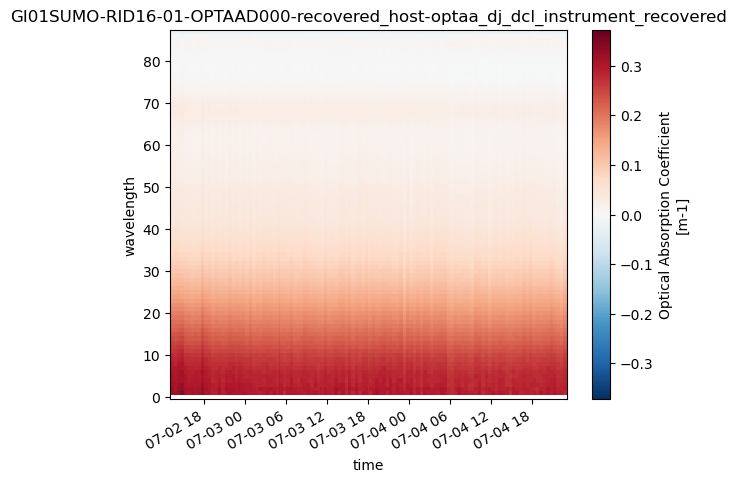

In [ ]:
data.optical_absorption.plot(x="time")
plt.title(data.id)
plt.show()

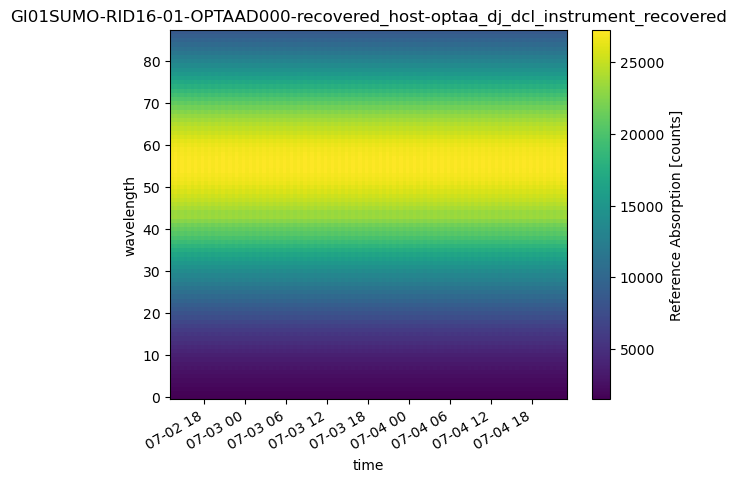

In [ ]:
data.a_reference_counts.plot(x="time")
plt.title(data.id)
plt.show()

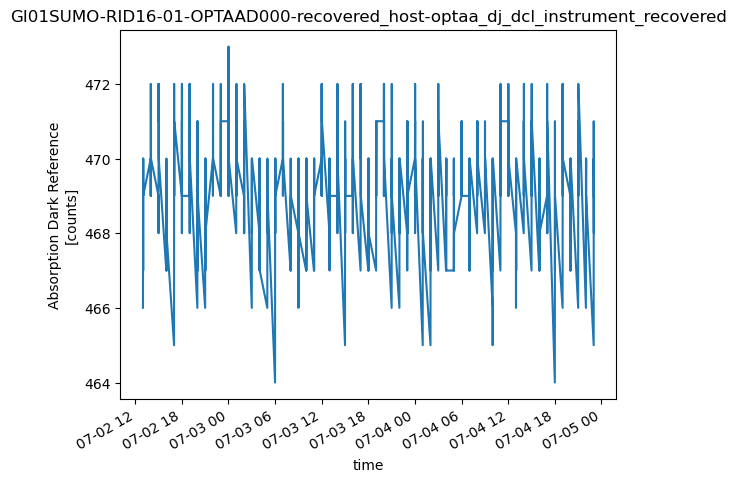

In [ ]:
data.a_reference_dark_counts.plot(x="time")
plt.title(data.id)
plt.show()

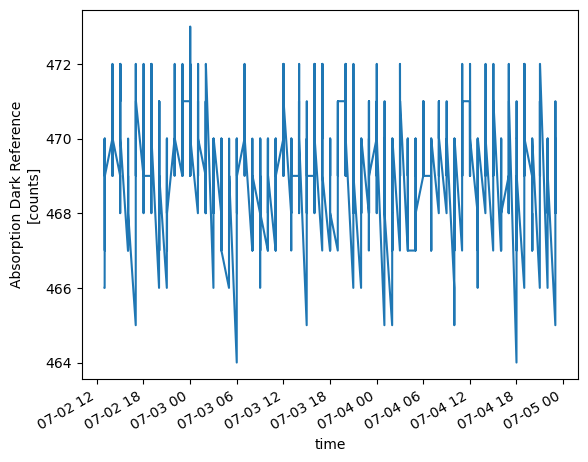

In [ ]:
data.a_reference_dark_counts.plot(x="time")


In [ ]:
# TO-DO: write function to add elements of figure
# most commonly used to give contextual info
def complete_the_plot(data):
    plt.title(data.id)